In [1]:
import datetime
import pytz
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
import matplotlib.ticker as mpticker
import pandas as pd
import numpy as np
import mplfinance as mpf

from pathlib import Path
from mpl_finance import candlestick_ohlc

C:\Anaconda3\envs\dev\lib\site-packages\mpl_finance.py:22: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  category=DeprecationWarning)


#### Download Cryptocurrency trading data

In [2]:
# Load the data into a Pandas DataFrame
df = pd.read_csv(
    Path('../Resources/BTCUSD_1h.csv'),
    index_col="Date")
df.tail()

,Open,Close,High,Low,Volume
Date,,,,,
2021-11-17 13:00:00,60514.231682,60207.000000,60639.0,60207.0,476.771475
2021-11-17 14:00:00,60207.000000,59724.666301,60388.0,59724.0,824.163709
2021-11-17 15:00:00,59724.000000,59708.630836,59859.0,59483.0,500.389504
2021-11-17 16:00:00,59728.000000,60418.000000,60480.0,59491.0,398.163219
2021-11-17 17:00:00,60418.000000,60069.000000,60439.0,60031.0,109.235020


#### Using hierarchical clustering -- Agglomerative Clustering approach on stocks rolling data

In [3]:
from sklearn.cluster import AgglomerativeClustering

def generate_SR_line(df,
                    rolling=20,
                    start=False, 
                    end=False, 
                    duration=False, 
                    n=3, 
                    figsize = (20, 10), 
                    plot=True):

    ''' 
    Credited to Mott The Tuple @ https://stackoverflow.com/questions/8587047/support-resistance-algorithm-technical-analysis/55311893#55311893
    --------------------------------------------------------------------------------------------------------------------------
    df = DataFrame 
    n = Number of Clusters / Number of Support/Resistance Line
    Start = Start index  e.g. 0 
    End = End index e.g. 100
    Duration = # of days used in S&R line from today
    --------------------------------------------------------------------------------------------------------------------------
    '''
    # Choose Date Range
    if duration == False:
        df = df.iloc[start:end]
    else:
        df = df.iloc[-(duration+rolling):] # for the rolling obs waves 
    Date = df.index
    
    # Reset_Index for merging 
    df.reset_index(inplace=True)
    
    # Create rolling stat for both max and min value
    max = df.High.rolling(rolling).max().rename('price')
    min = df.Low.rolling(rolling).min().rename('price')

    # Prepare data in two column format
    maxdf = pd.concat([max,pd.Series(np.zeros(len(max))+1)],axis = 1)
    mindf = pd.concat([min,pd.Series(np.zeros(len(min))+-1)],axis = 1)

    # Drop duplications
    maxdf.drop_duplicates('price',inplace = True)
    mindf.drop_duplicates('price',inplace = True)

    F = maxdf.append(mindf).sort_index()
    F = F[ F[0] != F[0].shift()].dropna()

    # Find Support/Resistance with clustering
    X = np.concatenate((F.price.values.reshape(-1,1),
                        (np.zeros(len(F))+1).reshape(-1,1)), axis = 1)

    # Clustering Algo -- fit the model
    cluster = AgglomerativeClustering(n_clusters=n,
                affinity='euclidean', linkage='ward')
    cluster.fit_predict(X)
    F['clusters'] = cluster.labels_

    # Get index of the max wave for each cluster
    F2 = F.loc[F.groupby('clusters')['price'].idxmax()]
    df.index = pd.DatetimeIndex(df['Date'])

    # Plotting 
    if plot == True:
        mpf.plot(df, type='candle', style='yahoo', volume=True,
                hlines=dict(hlines=F2.price.to_list(), colors='g', linestyle='dashed', alpha=0.7),figsize=figsize)
            
    F2.price.drop_duplicates(keep='first', inplace=True)
        
    return F2.reset_index().price

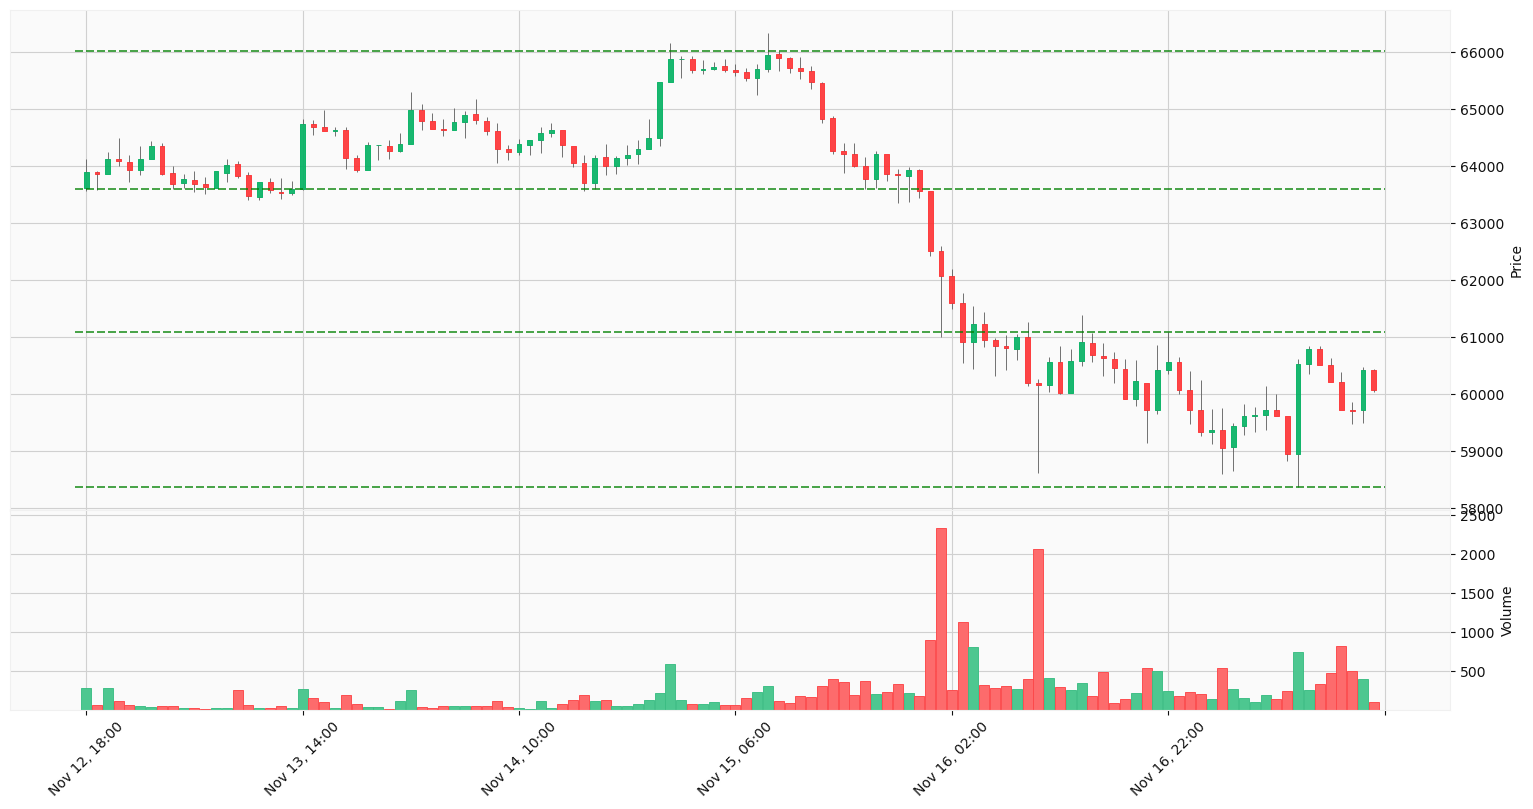

In [4]:
F2 = generate_SR_line(df, duration=100)

In [5]:
F2


0    61099.000000
1    58368.000000
2    66028.456099
3    63610.000000
Name: price, dtype: float64